# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [1]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=d8727838-144f-4605-86dc-1741109de352
To: /home/ysyang/ml/hw2/HW2.zip
100%|██████████████████████████████████████| 52.1M/52.1M [00:02<00:00, 24.9MB/s]


#### Import packages

In [ ]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [ ]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 128,
    n_epoch = 10,
    lr = 1e-4,
    weight_decay = 1e-7,
    ckpt_path = 'model.pth',
)

In [ ]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

#### Dataset and Dataloader

In [ ]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [ ]:
# TODO: define your augmentation for training and evaluation
train_tfm = T.Compose([
    # ...
    T.ToTensor(),
])
eval_tfm = T.Compose([
    # ...
    T.ToTensor(),
])

In [ ]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

#### Model

In [ ]:
# TODO: define your CNN model
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc(x)
        return x

#### training loop

In [ ]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training

100%|██████████| 181/181 [00:14<00:00, 12.18it/s]


Epoch: 1/10, train loss: 1.7990, train acc: 0.2549
Epoch: 1/10, valid loss: 1.7577, valid acc: 0.2775
== best valid acc: 0.2775 ==


100%|██████████| 181/181 [00:10<00:00, 17.11it/s]


Epoch: 2/10, train loss: 1.7141, train acc: 0.3107
Epoch: 2/10, valid loss: 1.6802, valid acc: 0.3499
== best valid acc: 0.3499 ==


100%|██████████| 181/181 [00:10<00:00, 16.77it/s]


Epoch: 3/10, train loss: 1.6379, train acc: 0.3677
Epoch: 3/10, valid loss: 1.6138, valid acc: 0.3786
== best valid acc: 0.3786 ==


100%|██████████| 181/181 [00:10<00:00, 17.34it/s]


Epoch: 4/10, train loss: 1.5936, train acc: 0.3902
Epoch: 4/10, valid loss: 1.5952, valid acc: 0.3861
== best valid acc: 0.3861 ==


100%|██████████| 181/181 [00:10<00:00, 17.32it/s]


Epoch: 5/10, train loss: 1.5691, train acc: 0.4000
Epoch: 5/10, valid loss: 1.5866, valid acc: 0.3851


100%|██████████| 181/181 [00:10<00:00, 16.79it/s]


Epoch: 6/10, train loss: 1.5525, train acc: 0.4045
Epoch: 6/10, valid loss: 1.5827, valid acc: 0.3862
== best valid acc: 0.3862 ==


100%|██████████| 181/181 [00:10<00:00, 17.39it/s]


Epoch: 7/10, train loss: 1.5393, train acc: 0.4115
Epoch: 7/10, valid loss: 1.5574, valid acc: 0.3982
== best valid acc: 0.3982 ==


100%|██████████| 181/181 [00:10<00:00, 17.37it/s]


Epoch: 8/10, train loss: 1.5276, train acc: 0.4157
Epoch: 8/10, valid loss: 1.5417, valid acc: 0.4069
== best valid acc: 0.4069 ==


100%|██████████| 181/181 [00:10<00:00, 17.30it/s]


Epoch: 9/10, train loss: 1.5147, train acc: 0.4206
Epoch: 9/10, valid loss: 1.5328, valid acc: 0.4096
== best valid acc: 0.4096 ==


100%|██████████| 181/181 [00:10<00:00, 17.48it/s]


Epoch: 10/10, train loss: 1.5022, train acc: 0.4270
Epoch: 10/10, valid loss: 1.5217, valid acc: 0.4161
== best valid acc: 0.4161 ==


<ipython-input-9-a166fffb6795>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.ckpt_path))


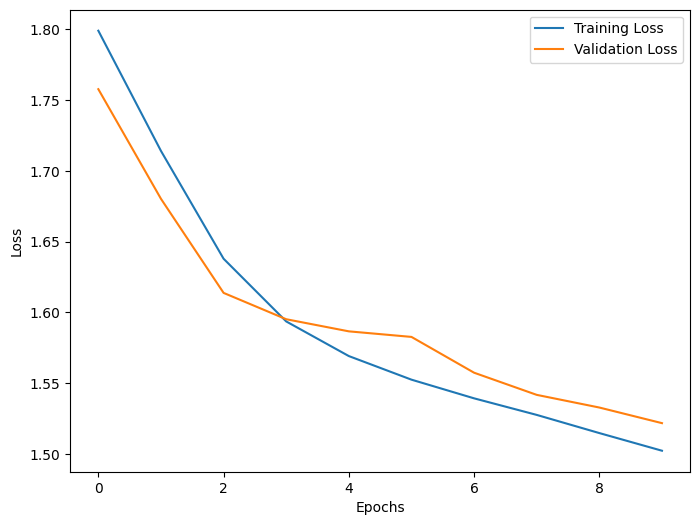

In [ ]:
model = FaceExpressionNet()
train(model, train_loader, valid_loader, config)

In [ ]:
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix
    pass

draw_confusion_matrix(model, valid_loader)

100%|██████████| 46/46 [00:02<00:00, 19.96it/s]


### Testing

In [ ]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [ ]:
model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)

<ipython-input-15-de5ed30657b4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))
100%|██████████| 55/55 [00:02<00:00, 19.22it/